In [28]:
# Setup & Imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import joblib
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Markdown
from utils.preprocessing import preprocess_features

# Load the pre-trained model
model = joblib.load("../model/model/readmission_rf_model.pkl")

In [ ]:
# Load prediction results for visualization

df_results = pd.read_csv("../model/output/risk_tiered_predictions.csv")

In [35]:
# Title & Instructions
# Patient Input Widgets

import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# Create Widgets
age_slider = widgets.IntSlider(description='Age', min=0, max=100, value=50,style={'description_width': 'initial'})
gender_dropdown = widgets.Dropdown(description='Gender', options=['Male', 'Female'],style={'description_width': 'initial'})
diagnosis_dropdown = widgets.Dropdown(description='Primary Diagnosis', options=['Heart Disease', 'COPD', 'Diabetes', 'Kidney Disease'],style={'description_width': 'initial'})
procedures_slider = widgets.IntSlider(description='Number of Procedures', min=0, max=10, value=1,style={'description_width': 'initial'})
days_in_hospital_slider = widgets.IntSlider(description='Days in Hospital', min=1, max=30, value=5,style={'description_width': 'initial'})
comorbidity_slider = widgets.IntSlider( description='Comorbidity Score', min=0, max=5, value=1,style={'description_width': 'initial'})
discharge_dropdown = widgets.Dropdown(description='Discharge To', options=['Home', 'Home Health Care', 'Rehabilitation Facility', 'Skilled Nursing Facility'],style={'description_width': 'initial'})

form = widgets.VBox([
    age_slider,
    gender_dropdown,
    diagnosis_dropdown,
    procedures_slider,
    days_in_hospital_slider,
    comorbidity_slider,
    discharge_dropdown
], layout=widgets.Layout(
    border='2px solid lightgray',
    padding='20px',
    margin='10px',
    width='600px',
    background_color='whitesmoke'  # Light background for clean UI
))

display(Markdown("## Enter Patient Information Below:"))
display(form)

In [31]:
# Define Callback Function
output_area = widgets.Output()

def predict_risk(b):
    output_area.clear_output()
    with output_area:
        # Collect inputs
        input_data = {
            'age': age_slider.value,
            'gender': gender_dropdown.value,
            'primary_diagnosis': diagnosis_dropdown.value,
            'num_procedures': procedures_slider.value,
            'days_in_hospital': days_in_hospital_slider.value,
            'comorbidity_score': comorbidity_slider.value,
            'discharge_to': discharge_dropdown.value
        }
        input_df = pd.DataFrame([input_data])
        processed_input = preprocess_features(input_df)
        prob = model.predict_proba(processed_input)[:,1][0]

        # Determine Risk Tier
        if prob >= 0.6:
            tier = "High"
        elif prob >= 0.3:
            tier = "Medium"
        else:
            tier = "Low"

        # Display Prediction
        display(Markdown(f"### Predicted 30-Day Readmission Risk Score: **{prob:.2f}**"))
        display(Markdown(f"### Predicted Risk Tier: **{tier}**"))

# Predict Button
predict_button = widgets.Button(
    description="Predict Risk",
    button_style='success',  # Green button
    tooltip='Click to predict risk'
)

predict_button.on_click(predict_risk)

display(predict_button)
display(output_area)

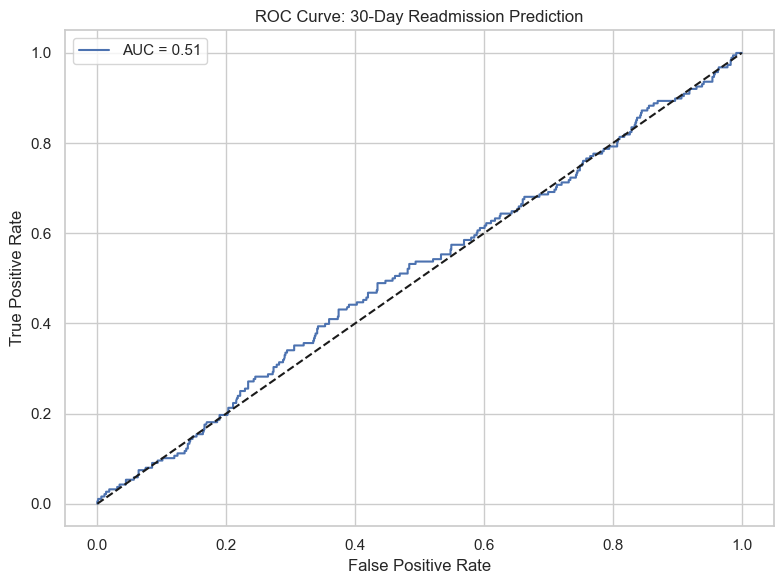

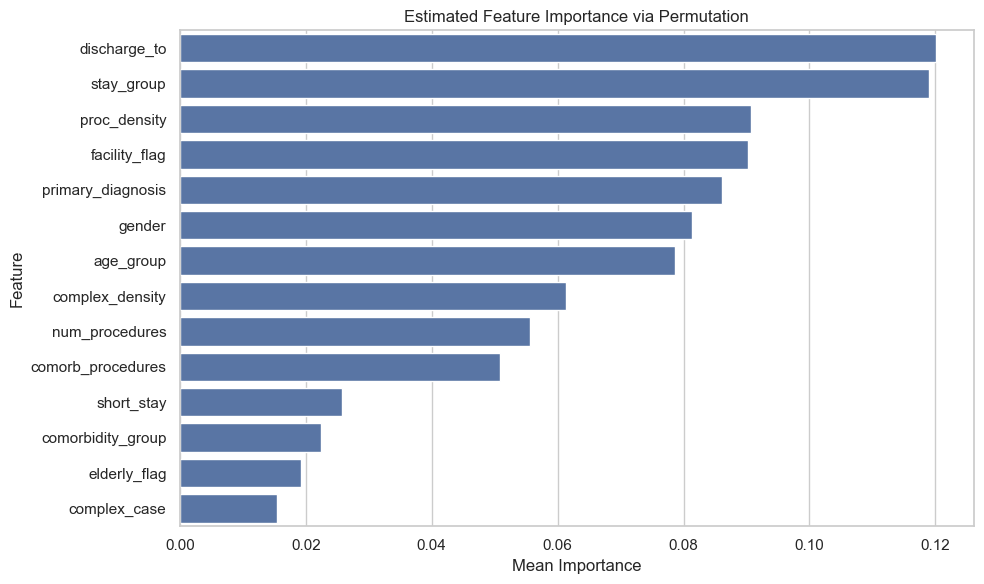

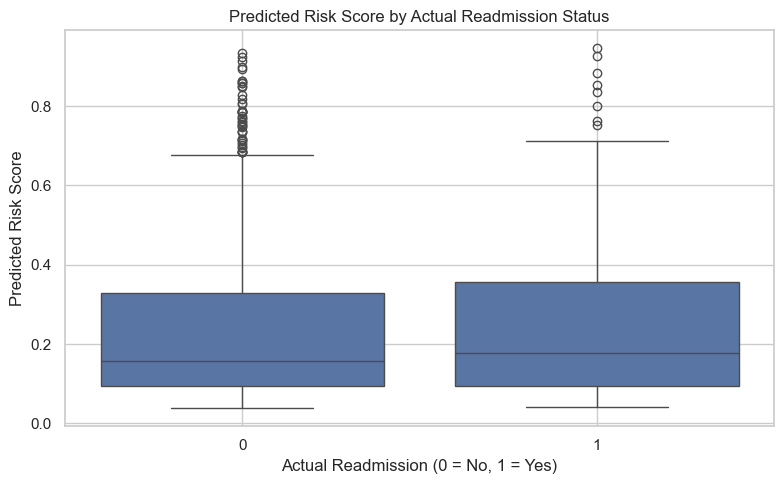

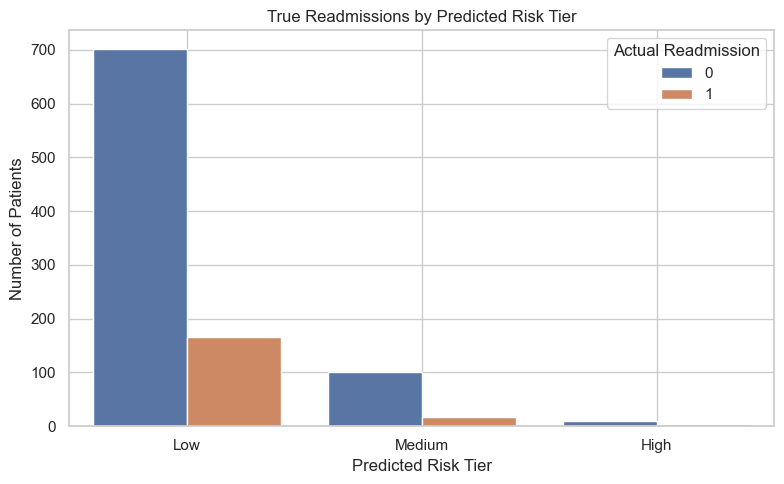

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

# Model Evaluation Visualizations

display(Markdown("# Model Evaluation Summary"))

# ROC Curve
display(Markdown("### ROC Curve"))
fpr, tpr, _ = roc_curve(df_results['actual_readmission'], df_results['readmission_probability'])
auc_score = roc_auc_score(df_results['actual_readmission'], df_results['readmission_probability'])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

display(Markdown("**Why this matters:** A higher AUC indicates better model ability to separate high-risk patients."))

# Feature Importance
display(Markdown("### Feature Importance"))
df_raw = pd.read_csv("../data/sample_data.csv")
X_raw = df_raw.drop(columns=["readmitted"])
y_raw = df_raw["readmitted"]
X_processed = preprocess_features(X_raw)

perm = permutation_importance(model, X_processed, y_raw, n_repeats=5, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance via Permutation')
plt.tight_layout()
plt.show()

display(Markdown("**Why this matters:** Understanding important features helps explain how predictions are made."))

# Boxplot Risk Score
display(Markdown("### Risk Score Distribution"))
plt.figure(figsize=(8,5))
sns.boxplot(data=df_results, x='actual_readmission', y='readmission_probability')
plt.title('Risk Scores by Actual Outcome')
plt.grid(True)
plt.tight_layout()
plt.show()

display(Markdown("**Why this matters:** Boxplots show how scores separate between true readmissions and non-readmissions."))

# Countplot Risk Tier
display(Markdown("### Risk Tier Breakdown"))
sns.countplot(data=df_results, x='risk_tier', hue='actual_readmission')
plt.title('Risk Tier Breakdown')
plt.xlabel('Predicted Risk Tier')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()

display(Markdown("**Why this matters:** Confirms whether the assigned tiers correspond well to actual patient outcomes."))


In [19]:
display(Markdown("# Summary & Reflection"))

from IPython.display import Markdown

Markdown('''
### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
''')



### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.


In [36]:
launch_instructions = """
## Launch Instructions (For Reviewers/Testers)

To view this notebook as a live interactive application:

1. Open this link in a new tab: [Launch via Voilà on Binder](https://mybinder.org/v2/gh/JeffAlexB/readmidtcheck/HEAD?urlpath=voila/render/app/notebook_interface.ipynb)
2. Wait ~1-2 minutes for Binder to build the environment.
3. Once loaded, enter example patient data and click **Predict Risk**.
4. The tool will display a personalized risk score and classification (Low / Medium / High).

If using locally:
```bash
pip install -r requirements.txt
voila app/notebook_interface.ipynb
```
"""
display(Markdown(launch_instructions))



## Launch Instructions (For Reviewers/testers)

To view this notebook as a live interactive application:

1. Open this link in a new tab: [Launch via Voilà on Binder](https://mybinder.org/v2/gh/JeffAlexB/readmidtcheck/HEAD?urlpath=voila/render/app/notebook_interface.ipynb)
2. Wait ~1-2 minutes for Binder to build the environment.
3. Once loaded, enter example patient data and click **Predict Risk**.
4. The tool will display a personalized risk score and classification (Low / Medium / High).

If using locally:
```bash
pip install -r requirements.txt
voila app/notebook_interface.ipynb
```
